# Check input files
**Author: Jun Sasaki  Coded on 2024-12-26  Updated on 2024-12-29**<br>
Checking input netcdf files

In [1]:
import xarray as xr
import os
#from xfvcom import Fvcom, FvcomPlotConfig, FvcomDataArray, FvcomPlotter
from xfvcom import FvcomDataLoader, FvcomAnalyzer, FvcomPlotConfig, FvcomPlotter
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def get_index_by_value(array, value):
    """
    指定された値のインデックスを返す関数

    Parameters:
        array (list or numpy.ndarray): 検索対象の配列（重複なし）
        value (int or float): 検索する値

    Returns:
        int: 配列内の値のインデックス（0から始まる）
    """
    try:
        # リストの場合
        return array.index(value)
    except AttributeError:
        # NumPy配列の場合
        index_array = np.where(array == value)[0]
        if index_array.size > 0:
            return int(index_array[0])  # 最初のインデックスを返す
        else:
            raise ValueError(f"{value} は配列内に存在しません。")
    except ValueError:
        raise ValueError(f"{value} は配列内に存在しません。")

In [3]:
'''
def get_ncpath(base_path, ncfile):
    base_path = os.path.expanduser(base_path)
    ncpath= f"{base_path}/{ncfile}"
    if os.path.isfile(ncpath):
        return ncpath
    else:
        print(f"ERROR: File not found: {ncpath}")
        return None
'''

'\ndef get_ncpath(base_path, ncfile):\n    base_path = os.path.expanduser(base_path)\n    ncpath= f"{base_path}/{ncfile}"\n    if os.path.isfile(ncpath):\n        return ncpath\n    else:\n        print(f"ERROR: File not found: {ncpath}")\n        return None\n'

In [4]:
base_path = "~/Github/TB-FVCOM/goto_dye/input/input_steady/2020"
ncfile = "obc_dye2020.nc"

In [5]:
#ncfile = "TokyoBay18_2020_wnd.nc"
#obc_dye2020 = Fvcom(base_path=base_path, ncfile=ncfile)
obc_dye2020 = FvcomDataLoader(base_path, ncfile, time_tolerance=5)

Dataset loaded successfully from /home/teem/Github/TB-FVCOM/goto_dye/input/input_steady/2020/obc_dye2020.nc


In [6]:
obc_dye2020.ds

<xarray.Dataset> Size: 101kB
Dimensions:    (time: 61, siglay: 30, nobc: 13, siglev: 31)
Coordinates:
  * time       (time) datetime64[ns] 488B 2020-01-01 2020-01-02 ... 2020-03-01
    siglay     (siglay, nobc) float32 2kB ...
    siglev     (siglev, nobc) float32 2kB ...
Dimensions without coordinates: nobc
Data variables:
    Itime      (time) datetime64[ns] 488B ...
    Times      (time) |S26 2kB ...
    obc_nodes  (nobc) int32 52B ...
    obc_h      (nobc) float32 52B ...
    obc_dye    (time, siglay, nobc) float32 95kB ...
Attributes:
    type:         FVCOM TIME SERIES OBC DYE FILE
    title:        Open boundary dye-release
    history:      File created using createNetCDF from mkncfile.py
    filename:     obc_dye2020.nc
    Conventions:  CF-1.0

In [7]:
obc_nodes = obc_dye2020.ds.obc_nodes.values
print(f"obc_nodes={obc_nodes}")

obc_nodes=[3150 3142 3137 3125 3123 3110 3100 3087 3074 3054 3037 3016 3015]


In [8]:
obc_node = 3150
obc_dye = obc_dye2020.ds['obc_dye']
obc_h = obc_dye2020.ds['obc_h']
obc_node_index = get_index_by_value(obc_nodes, obc_node)
time = obc_dye2020.ds['time']
siglay = obc_dye2020.ds['siglay'][:, obc_node_index]
dye_concentration = obc_dye[:, :, obc_node_index]
time_grid, siglay_grid = np.meshgrid(time, siglay)

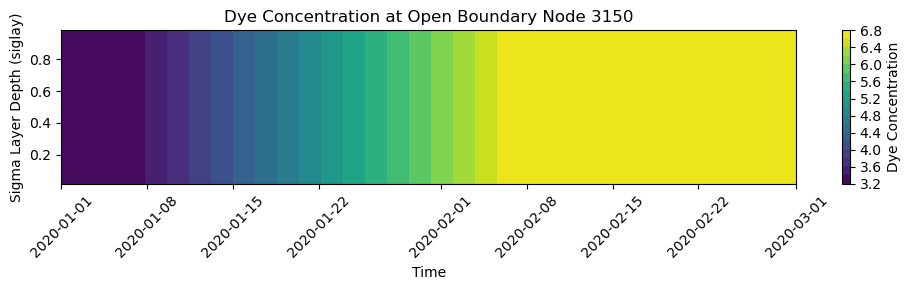

In [9]:
plt.figure(figsize=(10, 3))
plt.contourf(time_grid, siglay_grid, dye_concentration.T, cmap='viridis', levels=20)
plt.colorbar(label="Dye Concentration")
plt.xlabel("Time")
plt.ylabel("Sigma Layer Depth (siglay)")
plt.title(f"Dye Concentration at Open Boundary Node {obc_node}")
plt.xticks(rotation=45)
plt.tight_layout()
pngfile = f"dye_concentration_at_open_bound_node_{obc_node}.png"
plt.savefig(pngfile, dpi=300, bbox_inches='tight')
plt.show()

In [10]:
selected_time = '2020-01-01'
selected_time = np.datetime64(selected_time)
dye_profile = obc_dye.sel(time=selected_time, method='nearest')
depth = siglay * obc_h  # 各ノードごとの水深を計算
depth = depth.transpose('siglay', 'nobc') 
nobc_indices = np.tile(obc_h.nobc.values, (len(siglay), 1)) 
nobc_numbers = np.tile(obc_nodes, (len(siglay),1))
siglay_grid = np.tile(siglay.values[:, None], (1, len(obc_nodes)))

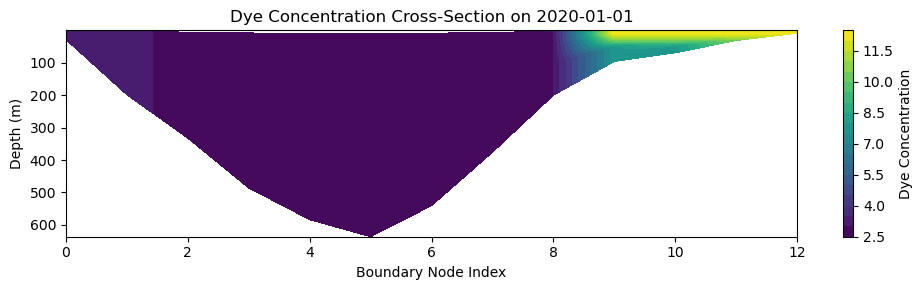

In [11]:
plt.close()
yaxis_siglay=False
plt.figure(figsize=(10, 3))
if yaxis_siglay:
    plt.contourf(
        nobc_indices, siglay_grid, dye_profile.values, levels=20, cmap='viridis'
    )
else:
    plt.contourf(
        nobc_indices, depth, dye_profile.values, levels=20, cmap='viridis'
    )
plt.colorbar(label="Dye Concentration")
plt.xlabel("Boundary Node Index")
plt.ylabel("Depth (m)")
plt.title(f"Dye Concentration Cross-Section on {selected_time}")
plt.gca().invert_yaxis()  # 水深を正の方向に（深くなるほど下へ）
#plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
import holoviews as hv
import panel as pn
import hvplot.xarray
from datetime import datetime
hv.extension('bokeh')
pn.extension()

In [13]:
ds = obc_dye2020.ds.copy()

In [14]:
node_select = pn.widgets.Select(
    name='Node Index',
    options=list(range(ds.sizes['nobc'])),  # 0〜12
    value=0
)

def plot_time_siglay(node):
    """
    指定したノードの染料濃度を時系列とsiglayに基づいてヒートマップとしてプロットします。
    """
    # 指定したノードのデータを抽出（nobcを削除）
    dye_profile = ds['obc_dye'].isel(nobc=node, drop=True)  # (time, siglay)
    
    # プロットは 'time' vs 'siglay'
    heatmap = dye_profile.hvplot.quadmesh(
        x='time',
        y='siglay',
        cmap='viridis',
        colorbar=True,
        title=f"Dye Concentration at Node {node} Over Time",
        xlabel='Time',
        ylabel='Sigma Layer'
    )
    
    return heatmap

# 動的なプロットを作成
#interactive_plot1 = pn.bind(plot_time_siglay, node=node_select)

# レイアウトの作成
#layout1 = pn.Column(
#    "# Dye Concentration Over Time",
#    node_select,
#    interactive_plot1
#)

In [15]:
interactive_plot1 = pn.bind(plot_time_siglay, node=node_select)

# レイアウトの作成
layout1 = pn.Column(
    "### Dye Concentration Over Time",
    node_select,
    interactive_plot1
)

In [16]:
final_layout = pn.Row(layout1)

In [17]:
final_layout

Row
    [0] Column
        [0] Markdown(str)
        [1] Select(name='Node Index', options=[0, 1, 2, 3, 4, ...], value=0)
        [2] ParamFunction(function, _pane=HoloViews, defer_load=False)

In [18]:
# 時間選択用のウィジェット
time_options = [pd.to_datetime(t).strftime('%Y-%m-%d %H:%M') for t in ds['time'].values]

time_select = pn.widgets.DiscreteSlider(
    name='Time',
    options=time_options,  # 文字列形式のリスト
    value=time_options[0]
)

def plot_node_depth(time):
    """
    指定した時間の染料濃度をノードインデックスと水深に基づいてヒートマップとしてプロットします。
    """
    # 選択された時間を np.datetime64 に変換
    time_np = np.datetime64(time)
    
    # 指定した時間のデータを抽出
    dye_profile = ds['obc_dye'].sel(time=time_np)  # (siglay, nobc)
    
    # ノードインデックスを0〜12に設定
    node_indices = np.arange(ds.sizes['nobc'])
    dye_profile = dye_profile.assign_coords(node_index=('nobc', node_indices))
    
    # siglayとobc_hを取得
    # siglayは (siglay, nobc) だが、全ノードで同じと仮定
    siglay_1d = ds['siglay'].isel(nobc=0).values  # (30,)
    obc_h_values = ds['obc_h'].values  # (13,)
    
    # 水深を計算: depth = siglay * obc_h
    depth = siglay_1d[:, np.newaxis] * obc_h_values  # shape (30,13)
    
    # depthを座標として追加
    dye_profile = dye_profile.assign_coords(depth=(['siglay', 'nobc'], depth))

    max_depth = depth.max()
    min_depth = depth.min()
    
    # プロット
    heatmap = dye_profile.hvplot.quadmesh(
        x='node_index',
        y='depth',
        cmap='viridis',
        colorbar=True,
        title=f"Dye Concentration at Time {time} by Depth",
        xlabel='Node Index',
        ylabel='Depth (m)',
        ylim=(max_depth, min_depth)
    )

    return heatmap

# 動的なプロットを作成
interactive_plot2 = pn.bind(plot_node_depth, time=time_select)

# レイアウトの作成
layout2 = pn.Column(
    "# Dye Concentration by Depth",
    time_select,
    interactive_plot2
)


In [19]:
final_layout = pn.Row(layout2)
final_layout

Row
    [0] Column
        [0] Markdown(str)
        [1] DiscreteSlider(name='Time', options=['2020-01-01 00:00', ...], value='2020-01-01 00:00')
        [2] ParamFunction(function, _pane=HoloViews, defer_load=False)

# Slice netcdf with time
To check netcdf files on PC, it is necessary to make their sizes much smaller; so slicing with time

In [20]:
base_path = "~/Github/TB-FVCOM/goto_dye/input/input_steady/2020"
ncfile = "TokyoBay18_2020_wnd.nc"
fvcom_wnd = FvcomDataLoader(base_path=base_path, ncfile=ncfile, time_tolerance=5)

Dataset loaded successfully from /home/teem/Github/TB-FVCOM/goto_dye/input/input_steady/2020/TokyoBay18_2020_wnd.nc


In [21]:
start = "2020-01-01 00:00:00"
end = "2020-01-07 00:00:00"
output_path = f"sliced_{ncfile}"
fvcom_wnd.slice_by_time(start, end).to_netcdf(output_path)

Slicing successful: Dataset sliced from 2020-01-01T00:00:00 to 2020-01-07T00:00:00.


In [22]:
fvcom_wnd.ds

<xarray.Dataset> Size: 1GB
Dimensions:            (node: 3210, nele: 5645, three: 3, time: 8785,
                        dim_0: 5645, dim_1: 3)
Coordinates:
  * time               (time) datetime64[ns] 70kB 2020-01-01 ... 2021-01-01
Dimensions without coordinates: node, nele, three, dim_0, dim_1
Data variables: (12/20)
    x                  (node) float64 26kB ...
    y                  (node) float64 26kB ...
    lon                (node) float64 26kB 139.8 139.8 139.8 ... 139.9 139.8
    lat                (node) float64 26kB 35.65 35.65 35.65 ... 34.99 34.99
    xc                 (nele) float64 45kB ...
    yc                 (nele) float64 45kB ...
    ...                 ...
    long_wave          (time, node) float32 113MB ...
    relative_humidity  (time, node) float32 113MB ...
    air_pressure       (time, node) float32 113MB ...
    Precipitation      (time, node) float32 113MB ...
    nv_zero            (dim_0, dim_1) int32 68kB 1 0 2 0 ... 3207 3209 3208 3206
    nv_ccw             (nele, three) int32 68kB 2 0 1 2 ... 3209 3206 3208 3209
Attributes:
    type:                  FVCOM Forcing File
    title:                 FVCOM Forcing File
    institution:           Sasaki Lab, The University of Tokyo
    source:                FVCOM grid (unstructured) surface forcing
    history:               File created with write_FVCOM_forcing from the MAT...
    references:            http://fvcom.smast.umassd.edu, http://codfish.smas...
    Conventions:           CF-1.0
    infos:                 GWO atmospheric forcing data
    CoordinateSystem:      cartesian
    CoordinateProjection:  init=WGS84

In [23]:
start = "2020-01-01 00:00:00"
end = "2020-01-07 00:00:00"
base_path = "~/Github/TB-FVCOM/goto_dye/input/input_steady/2020"
ncfiles = ["TokyoBay2020final_tsobc.nc", "TokyoBay2020julian_obc.nc",
           "TokyoBay2020kisarazufinal_sewer.nc", "TokyoBay2020final_river.nc",
           "TokyoBay2020final_sewer.nc"]
for ncfile in ncfiles:
    output_path = f"sliced_{ncfile}"
    fvcom = FvcomDataLoader(base_path=base_path, ncfile=ncfile, time_tolerance=5)
    fvcom.slice_by_time(start, end).to_netcdf(output_path)

Dataset loaded successfully from /home/teem/Github/TB-FVCOM/goto_dye/input/input_steady/2020/TokyoBay2020final_tsobc.nc
Slicing successful: Dataset sliced from 2020-01-01T00:00:00 to 2020-01-07T00:00:00.
Dataset loaded successfully from /home/teem/Github/TB-FVCOM/goto_dye/input/input_steady/2020/TokyoBay2020julian_obc.nc
Slicing successful: Dataset sliced from 2020-01-01T00:00:00 to 2020-01-07T00:00:00.
Dataset loaded successfully from /home/teem/Github/TB-FVCOM/goto_dye/input/input_steady/2020/TokyoBay2020kisarazufinal_sewer.nc
Slicing successful: Dataset sliced from 2020-01-01T00:00:00 to 2020-01-07T00:00:00.
Dataset loaded successfully from /home/teem/Github/TB-FVCOM/goto_dye/input/input_steady/2020/TokyoBay2020final_river.nc
Slicing successful: Dataset sliced from 2020-01-01T00:00:00 to 2020-01-07T00:00:00.
Dataset loaded successfully from /home/teem/Github/TB-FVCOM/goto_dye/input/input_steady/2020/TokyoBay2020final_sewer.nc
Slicing successful: Dataset sliced from 2020-01-01T00:00: